## MobileNet

In [1]:
###### check gpu
import tensorflow as tf
from tensorflow.python.client import device_lib
import pandas as pd
import numpy as np
import glob
import random
import locale
from PIL import Image
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow import keras
#import tensorflow_addons as tfa
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4
from tensorflow.keras import layers, models, Model, Input
from tensorflow.keras.layers import concatenate, Input, Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, History
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredError
from tensorflow.keras.utils import plot_model

from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.layers.core import Activation,Dropout,Dense
from tensorflow.keras.optimizers import Adam

import string
from keras.preprocessing import image as krs_image

# feature selection libraries
from sklearn.feature_selection import RFE

In [2]:
color_gt = ['RGB-R', 'RGB-G','RGB-B','HSL-H','HSL-S','HSL-L']
object_gt = ['aeroplane','apple','backpack','banana','baseball bat','baseball glove','bear','bed','bench','bicycle',
'bird','boat','book','bottle','bowl','broccoli','bus','cake','car','carrot','cat','cell phone','chair',
'clock','cow','cup','diningtable','dog','donut','elephant','fire hydrant','fork','frisbee','giraffe',
'handbag','horse','hot dog','keyboard','kite','knife','laptop','microwave','motorbike','mouse','orange',
'oven','parking meter','person','pizza','pottedplant','refrigerator','remote','sandwich','scissors','sheep',
'sink','skateboard','skis','snowboard','sofa','spoon','sports ball','stop sign','suitcase','surfboard',
'teddy bear','tennis racket','tie','toilet','toothbrush','traffic light','train','truck','tvmonitor','umbrella',
'vase','wine glass','zebra']
scene_gt = ['Indoor/Outdoor','shopping and dining','workplace (office building, factory, lab, etc.)',
'home or hotel','transportation (vehicle interiors, stations, etc.)','sports and leisure','cultural (art, education, religion, millitary, law, politics, etc.)',
'water, ice, snow','mountains, hills, desert, sky','forest, field, jungle','man-made elements','transportation (roads, parking, bridges, boats, airports, etc.)',
'cultural or historical building/place (millitary, religious)','sports fields, parks, leisure spaces','industrial and construction','houses, cabins, gardens, and farms',
'commercial buildings, shops, markets, cities, and towns','airfield','airplane_cabin','airport_terminal','alcove','alley','amphitheater','amusement_arcade',
'amusement_park','apartment_building/outdoor','aquarium','aqueduct','arcade','arch','archaelogical_excavation','archive','arena/hockey','arena/performance',
'arena/rodeo','army_base','art_gallery','art_school','art_studio','artists_loft','assembly_line','athletic_field/outdoor','atrium/public','attic','auditorium',
'auto_factory','auto_showroom','badlands','bakery/shop','balcony/exterior','balcony/interior','ball_pit','ballroom','bamboo_forest','bank_vault','banquet_hall',
'bar','barn','barndoor','baseball_field','basement','basketball_court/indoor','bathroom','bazaar/indoor','bazaar/outdoor','beach','beach_house','beauty_salon',
'bedchamber','bedroom','beer_garden','beer_hall','berth','biology_laboratory','boardwalk','boat_deck','boathouse','bookstore','booth/indoor','botanical_garden',
'bow_window/indoor','bowling_alley','boxing_ring','bridge','bullring','burial_chamber','bus_interior','bus_station/indoor','butchers_shop','butte','cabin/outdoor',
'campsite','campus','canal/natural','canal/urban','candy_store','canyon','car_interior','carrousel','castle','catacomb','cemetery','chalet','chemistry_lab',
'childs_room','church/indoor','church/outdoor','classroom','clean_room','cliff','closet','clothing_store','coast','cockpit','coffee_shop','computer_room',
'conference_center','conference_room','construction_site','corn_field','corral','corridor','cottage','courthouse','courtyard','creek','crevasse','crosswalk',
'dam','delicatessen','department_store','desert/sand','desert/vegetation','desert_road','diner/outdoor','dining_hall','dining_room','discotheque','doorway/outdoor',
'dorm_room','downtown','dressing_room','driveway','drugstore','elevator/door','elevator_lobby','elevator_shaft','embassy','engine_room','entrance_hall',
'escalator/indoor','excavation','fabric_store','farm','fastfood_restaurant','field/cultivated','field/wild','field_road','fire_escape','fire_station','fishpond',
'flea_market/indoor','florist_shop/indoor','food_court','football_field','forest/broadleaf','forest_path','forest_road','formal_garden','fountain','galley',
'garage/indoor','garage/outdoor','gas_station','gazebo/exterior','general_store/indoor','general_store/outdoor','gift_shop','glacier','golf_course','greenhouse/indoor',
'greenhouse/outdoor','grotto','gymnasium/indoor','hangar/indoor','hangar/outdoor','harbor','hardware_store','hayfield','heliport','highway','home_office',
'home_theater','hospital','hospital_room','hot_spring','hotel/outdoor','hotel_room','house','hunting_lodge/outdoor','ice_cream_parlor','ice_floe','ice_shelf',
'ice_skating_rink/indoor','ice_skating_rink/outdoor','iceberg','igloo','industrial_area','inn/outdoor','islet','jacuzzi/indoor','jail_cell','japanese_garden',
'jewelry_shop','junkyard','kasbah','kennel/outdoor','kindergarden_classroom','kitchen','lagoon','lake/natural','landfill','landing_deck','laundromat','lawn',
'lecture_room','legislative_chamber','library/indoor','library/outdoor','lighthouse','living_room','loading_dock','lobby','lock_chamber','locker_room','mansion',
'manufactured_home','market/indoor','market/outdoor','marsh','martial_arts_gym','mausoleum','medina','mezzanine','moat/water','mosque/outdoor','motel','mountain',
'mountain_path','mountain_snowy','movie_theater/indoor','museum/indoor','museum/outdoor','music_studio','natural_history_museum','nursery','nursing_home','oast_house',
'ocean','office','office_building','office_cubicles','oilrig','operating_room','orchard','orchestra_pit','pagoda','palace','pantry','park','parking_garage/indoor',
'parking_garage/outdoor','parking_lot','pasture','patio','pavilion','pet_shop','pharmacy','phone_booth','physics_laboratory','picnic_area','pier','pizzeria','playground',
'playroom','plaza','pond','porch','promenade','pub/indoor','racecourse','raceway','raft','railroad_track','rainforest','reception','recreation_room','repair_shop',
'residential_neighborhood','restaurant','restaurant_kitchen','restaurant_patio','rice_paddy','river','rock_arch','roof_garden','rope_bridge','ruin','runway','sandbox',
'sauna','schoolhouse','science_museum','server_room','shed','shoe_shop','shopfront','shopping_mall/indoor','shower','ski_resort','ski_slope','sky','skyscraper','slum',
'snowfield','soccer_field','stable','stadium/baseball','stadium/football','stadium/soccer','stage/indoor','stage/outdoor','staircase','storage_room','street',
'subway_station/platform','supermarket','sushi_bar','swamp','swimming_hole','swimming_pool/indoor','swimming_pool/outdoor','synagogue/outdoor','television_room',
'television_studio','temple/asia','throne_room','ticket_booth','topiary_garden','tower','toyshop','train_interior','train_station/platform','tree_farm','tree_house',
'trench','tundra','underwater/ocean_deep','utility_room','valley','vegetable_garden','veterinarians_office','viaduct','village','vineyard','volcano',
'volleyball_court/outdoor','waiting_room','water_park','water_tower','waterfall','watering_hole','wave','wet_bar','wheat_field','wind_farm','windmill','yard',
'youth_hostel','zen_garden']

In [3]:
# image features data in csv
train_x_data = pd.read_csv('../../data/train_x_rounded.csv', index_col ='iid')
test_x_data = pd.read_csv('../../data/test_x_rounded.csv',index_col ="iid")
valid_x_data = pd.read_csv('../../data/valid_x_rounded.csv',index_col ="iid")

# rejected_features = color_gt + scene_gt + ['boat', 'car_interior', 'forest, field, jungle', 'forest/broadleaf']
rejected_features = color_gt

train_x_data.drop(columns=rejected_features,inplace=True)
test_x_data.drop(columns=rejected_features,inplace=True)
valid_x_data.drop(columns=rejected_features,inplace=True)

trainAttrX = train_x_data

train_y_data = pd.read_csv('../../data/train_y.csv', index_col ='iid')
test_y_data = pd.read_csv('../../data/test_y.csv',index_col ="iid")
valid_y_data = pd.read_csv('../../data/valid_y.csv',index_col ="iid")

In [4]:
train_x_data

,aeroplane,apple,backpack,banana,baseball bat,baseball glove,bear,bed,bench,bicycle,...,waterfall,watering_hole,wave,wet_bar,wheat_field,wind_farm,windmill,yard,youth_hostel,zen_garden
iid,,,,,,,,,,,,,,,,,,,,,
I000259252.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
I000296556.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
I000193784.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
I000793950.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
I000872207.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
I000583119.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
I000981321.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
I000149626.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
I000833174.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### With Images

In [5]:
# image data 
train_file_list = glob.glob('../../train/*.jpg', recursive = True)
random.shuffle(train_file_list)

test_file_list = glob.glob('../../test/*.jpg', recursive = True)
random.shuffle(test_file_list)

valid_file_list = glob.glob('../../valid/*.jpg', recursive = True)
random.shuffle(valid_file_list)

In [6]:
train_file_list = [x for x in train_file_list if "(1)" not in x]

In [7]:
test_file_list = [x for x in test_file_list if "(1)" not in x]

In [8]:
valid_file_list = [x for x in valid_file_list if "(1)" not in x]

In [9]:
len(train_file_list)

58174

In [10]:
len(test_file_list)

12467

In [11]:
len(valid_file_list)

12466

In [12]:
# data generator

# Create the arguments for image preprocessing
data_gen_args = dict(
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    shear_range=10,
    channel_shift_range=50,
    rescale=1. / 255,
)

# Create an empty data generator
datagen = ImageDataGenerator()

def my_gen(images_list, dataframe, df_y, batch_size):
    i = 0
    while True:
        batch = {'img_input': [], 'csv_input': [], 'valence': [], 'arousal': [], 'dominance': []}
        for b in range(batch_size):
            if i == len(images_list):
                i = 0
                random.shuffle(images_list)
            # Read image from list and convert to array
            image_path = images_list[i]
            image_name = os.path.basename(image_path).replace('.JPG', '')
            #image = tf.keras.utils.load_img(image_path, target_size=(224, 224)) 
            image = krs_image.load_img(image_path, target_size=(224, 224)) #image height & width
            image = datagen.apply_transform(image, data_gen_args)
            image = krs_image.img_to_array(image)
            #image = tf.keras.utils.img_to_array(image)

            # Read data from csv using the name of current image
            csv_features = dataframe.loc[image_name, :]
            y = df_y.loc[image_name, :]
            val_train = y[0]
            aro_train = y[1]
            dom_train = y[2]

            #print(image_name)
            batch['img_input'].append(image)
            batch['csv_input'].append(csv_features)
            batch['valence'].append(val_train)
            batch['arousal'].append(aro_train)
            batch['dominance'].append(dom_train)

            i += 1

        batch['img_input'] = np.array(batch['img_input'])
        batch['csv_input'] = np.array(batch['csv_input'])
        batch['valence'] = np.array(batch['valence'])
        batch['arousal'] = np.array(batch['arousal'])
        batch['dominance'] = np.array(batch['dominance'])
        

        yield [batch['img_input']], [batch['valence'],batch['arousal'],batch['dominance']]

gen_train = my_gen(train_file_list, train_x_data, train_y_data, 32)
gen_test = my_gen(test_file_list, test_x_data, test_y_data, 32)
gen_valid = my_gen(valid_file_list, valid_x_data, valid_y_data, 32)

In [13]:
def create_mlp(dim):
	# define our MLP network
	model = Sequential()
	model.add(Dense(512, input_dim=dim, activation="relu", name='csv'))
	model.add(Dense(256, activation="relu"))
	model.add(Dense(128, activation="relu"))
	model.add(Dense(64, activation="relu"))    
    
	return model

In [14]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 

def create_mobilenet(width, height, depth):
    # inputs= Input(shape=(width, height, depth), name='img_input')  

    res = MobileNetV2(
        weights='imagenet',  
        include_top=False,  
        input_shape = (width, height, depth),  
    )

    for layer in res.layers:  
        layer.trainable = False #false: freeze, true:train by own

    x = layers.BatchNormalization()(res.output)
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    x = layers.Flatten()(x)

    model = Model(res.input, x, name="ResNet")
    return model

In [15]:
mobilenet = create_mobilenet(224, 224, 3)
mobilenet.summary()

wise_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 14, 14, 64)   12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 14, 14, 64)   256         block_6_project[0][0]            
__________________________________________________________________________________________________
block_7_expand (Conv2D)         (None, 14, 14, 384)  24576       block_6_project_BN[0][0]         
__________________________________________________________________________________________________
block_7_expand_BN (BatchNormali (None, 14, 14, 384)  1536        block_7_expand[0][0]             
__________________________________________________________________________________________________
block_7_expand_relu (ReLU)      (None, 14, 14, 384)  0           block_7_expand_BN[0][0]

In [16]:
from tensorflow.keras.optimizers import Adam

x = Dense(1024, activation="relu",name='csv_img')(mobilenet.output)
x = Dense(512, activation="relu")(x)

valence_output = Dense(units=1, activation='linear', name='valence_output')(x)
arousal_output = Dense(units=1, activation='linear', name='arousal_output')(x)
dominance_output = Dense(units=1, activation='linear', name='dominance_output')(x)

model = Model(inputs=[mobilenet.input], outputs=[valence_output, arousal_output, dominance_output])

opt = Adam(learning_rate=0.001)

model.compile(optimizer=opt, run_eagerly=True,
              loss={'valence_output': 'mse', 'arousal_output': 'mse', 'dominance_output': 'mse'},
              metrics={'valence_output': 'mae', 'arousal_output': 'mae', 'dominance_output': 'mae'})


In [17]:
model.summary()

][0]          
__________________________________________________________________________________________________
block_7_depthwise (DepthwiseCon (None, 14, 14, 384)  3456        block_7_expand_relu[0][0]        
__________________________________________________________________________________________________
block_7_depthwise_BN (BatchNorm (None, 14, 14, 384)  1536        block_7_depthwise[0][0]          
__________________________________________________________________________________________________
block_7_depthwise_relu (ReLU)   (None, 14, 14, 384)  0           block_7_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_7_project (Conv2D)        (None, 14, 14, 64)   24576       block_7_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_7_project_BN (BatchNormal (None, 14, 14, 64)   256         block_7_project[0][0]        

In [19]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001),
    ModelCheckpoint('./trained_models/MobileNet-2-layer', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
]

batch_size = 32
trainidx = len(train_file_list)
testidx = len(test_file_list)
valididx = len(valid_file_list)

nce_output_loss: 0.4863 - val_valence_output_mae: 0.8850 - val_arousal_output_mae: 0.4053 - val_dominance_output_mae: 0.5238
Epoch 12/1000
1818/1817 [==============================] - ETA: 0s - loss: 1.5032 - valence_output_loss: 0.8950 - arousal_output_loss: 0.2777 - dominance_output_loss: 0.3304 - valence_output_mae: 0.7413 - arousal_output_mae: 0.3833 - dominance_output_mae: 0.4332
Epoch 00012: val_loss did not improve from 1.68543
1818/1817 [==============================] - 382s 210ms/step - loss: 1.5032 - valence_output_loss: 0.8950 - arousal_output_loss: 0.2777 - dominance_output_loss: 0.3304 - valence_output_mae: 0.7413 - arousal_output_mae: 0.3833 - dominance_output_mae: 0.4332 - val_loss: 1.9848 - val_valence_output_loss: 1.1468 - val_arousal_output_loss: 0.4452 - val_dominance_output_loss: 0.3928 - val_valence_output_mae: 0.8396 - val_arousal_output_mae: 0.5126 - val_dominance_output_mae: 0.4702
Epoch 13/1000
1818/1817 [==============================] - ETA: 0s - loss: 1.577

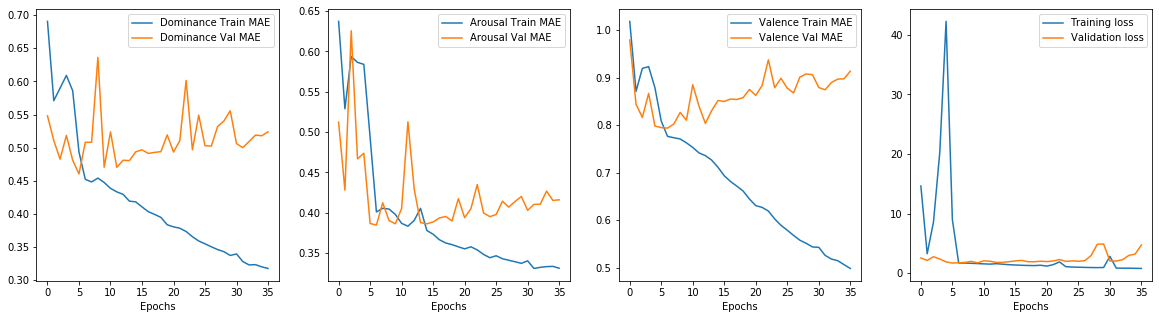

In [20]:
history = model.fit(gen_train, epochs=1000, steps_per_epoch=trainidx/batch_size, validation_data=gen_valid, validation_steps=valididx/batch_size, callbacks=callbacks, batch_size=16)

def plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].plot(history.history['dominance_output_mae'], label='Dominance Train MAE')
    axes[0].plot(history.history['val_dominance_output_mae'], label='Dominance Val MAE')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()

    axes[1].plot(history.history['arousal_output_mae'], label='Arousal Train MAE')
    axes[1].plot(history.history['val_arousal_output_mae'], label='Arousal Val MAE')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['valence_output_mae'], label='Valence Train MAE')
    axes[2].plot(history.history['val_valence_output_mae'], label='Valence Val MAE')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()  

    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

plot_train_history(history)

model.save('b4_mixedinput_fc_1024_512.h5')

### Fine-tuning

In [18]:
from tensorflow.keras.models import load_model

model = load_model("./trained_models/MobileNet-2-layer")

In [19]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable = False

for layer in model.layers[fine_tune_at:]:
  layer.trainable = True


Number of layers in the base model:  163


In [20]:
model.summary()

[0][0]          
__________________________________________________________________________________________________
block_7_depthwise (DepthwiseCon (None, 14, 14, 384)  3456        block_7_expand_relu[0][0]        
__________________________________________________________________________________________________
block_7_depthwise_BN (BatchNorm (None, 14, 14, 384)  1536        block_7_depthwise[0][0]          
__________________________________________________________________________________________________
block_7_depthwise_relu (ReLU)   (None, 14, 14, 384)  0           block_7_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_7_project (Conv2D)        (None, 14, 14, 64)   24576       block_7_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_7_project_BN (BatchNormal (None, 14, 14, 64)   256         block_7_project[0][0]      

In [21]:
opt = Adam(learning_rate=0.0001)

model.compile(optimizer=opt, run_eagerly=True,
              loss={'valence_output': 'mse', 'arousal_output': 'mse', 'dominance_output': 'mse'},
              metrics={'valence_output': 'mae', 'arousal_output': 'mae', 'dominance_output': 'mae'})


In [19]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001),
    ModelCheckpoint('./trained_models/MobileNet-2-layer-finetuned', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
]

batch_size = 32
trainidx = len(train_file_list)
testidx = len(test_file_list)
valididx = len(valid_file_list)

nance_output_loss: 0.6156 - val_valence_output_mae: 0.8486 - val_arousal_output_mae: 0.4080 - val_dominance_output_mae: 0.6219
Epoch 7/1000
1818/1817 [==============================] - ETA: 0s - loss: 0.8688 - valence_output_loss: 0.4258 - arousal_output_loss: 0.2700 - dominance_output_loss: 0.1730 - valence_output_mae: 0.5105 - arousal_output_mae: 0.3754 - dominance_output_mae: 0.3267
Epoch 00007: val_loss did not improve from 1.65286
1818/1817 [==============================] - 407s 224ms/step - loss: 0.8688 - valence_output_loss: 0.4258 - arousal_output_loss: 0.2700 - dominance_output_loss: 0.1730 - valence_output_mae: 0.5105 - arousal_output_mae: 0.3754 - dominance_output_mae: 0.3267 - val_loss: 2.4798 - val_valence_output_loss: 1.3507 - val_arousal_output_loss: 0.3040 - val_dominance_output_loss: 0.8251 - val_valence_output_mae: 0.9205 - val_arousal_output_mae: 0.4015 - val_dominance_output_mae: 0.7214
Epoch 8/1000
1818/1817 [==============================] - ETA: 0s - loss: 1.259

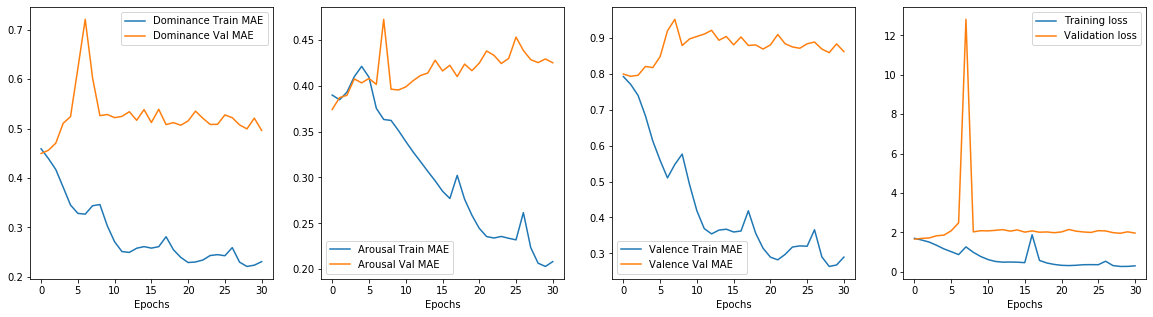

In [23]:
history = model.fit(gen_train, epochs=1000, steps_per_epoch=trainidx/batch_size, validation_data=gen_valid, validation_steps=valididx/batch_size, callbacks=callbacks, batch_size=32)

def plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].plot(history.history['dominance_output_mae'], label='Dominance Train MAE')
    axes[0].plot(history.history['val_dominance_output_mae'], label='Dominance Val MAE')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()

    axes[1].plot(history.history['arousal_output_mae'], label='Arousal Train MAE')
    axes[1].plot(history.history['val_arousal_output_mae'], label='Arousal Val MAE')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['valence_output_mae'], label='Valence Train MAE')
    axes[2].plot(history.history['val_valence_output_mae'], label='Valence Val MAE')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()  

    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

plot_train_history(history)

model.save('b4_mixedinput_fc_1024_512.h5')

Best validation loss: 1.65286

## Testing

In [17]:
from tensorflow.keras.models import load_model

model = load_model("./trained_models/MobileNet-2-layer-finetuned")

In [20]:
model.evaluate(gen_test, steps=testidx/batch_size)

390/389 [==============================] - 59s 152ms/step - loss: 1.6555 - valence_output_loss: 1.0218 - arousal_output_loss: 0.2772 - dominance_output_loss: 0.3565 - valence_output_mean_absolute_error: 0.7946 - arousal_output_mean_absolute_error: 0.3769 - dominance_output_mean_absolute_error: 0.4441


[1.655513048171997,
 1.0218132734298706,
 0.27721142768859863,
 0.35648825764656067,
 0.7945554852485657,
 0.37686124444007874,
 0.4441303014755249]